### Search using facebook FAISS
[faiss](https://github.com/facebookresearch/faiss)

In [2]:
import json
# Used to import data from S3.
import pandas as pd

# Used to create the dense document vectors.
import torch
from sentence_transformers import SentenceTransformer

# Used to create and store the Faiss index.
import faiss
import numpy as np
import pickle
import matplotlib.pyplot as plt

# Used to do vector searches and display the results.
#from vector_engine.utils import vector_search, id2details

### Import
Import the file exported from the excel file

In [39]:
defFile = "primitiveDef.json"

with open('D:/1. Papers/4. MyPapers/6_(20210609) Skill taxonomy/skill-taxonomy-extraction/data/in/' + str(defFile)) as json_file:
    defWord = json.load(json_file)

#print(defWord)

# Preprocessing
Follow guide from: https://www.pinecone.io/learn/faiss-tutorial/

In [40]:
# remove duplicates
defSing = [word for word in list(set(defWord)) if type(word) is str]

In [41]:
from sentence_transformers import SentenceTransformer
# initialize sentence transformer model
#model = SentenceTransformer('bert-base-nli-mean-tokens') #this is outdated: https://huggingface.co/sentence-transformers/bert-base-nli-mean-tokens
# info: https://www.sbert.net/docs/pretrained_models.html
model = SentenceTransformer('all-mpnet-base-v2')
# create sentence embeddings
sentence_embeddings = model.encode(defSing)
sentence_embeddings.shape
#print(sentence_embeddings)

(140, 768)

Here he use the clustering provided in the [faiss-wiki](https://github.com/facebookresearch/faiss/wiki/Faiss-building-blocks:-clustering,-PCA,-quantization)

In [5]:
import faiss

d = sentence_embeddings.shape[1]
index = faiss.IndexFlatL2(d)
index.is_trained
index.add(sentence_embeddings)
index.ntotal
print(len(sentence_embeddings[0]))

768


In [6]:
# We decompose with sklearn PCA
from sklearn.decomposition import PCA

pca = PCA(n_components=2)

principalComponents = pca.fit_transform(sentence_embeddings)

x = principalComponents[:,0].tolist()
y = principalComponents[:,1].tolist()
principalComponents = np.ascontiguousarray(principalComponents)

# We decompose with faiss PCA
mat = faiss.PCAMatrix(768, 2)
mat.train(sentence_embeddings)
assert mat.is_trained
tr = mat.apply_py(sentence_embeddings)
xf = tr[:,0].tolist()
yf = tr[:,1].tolist()

Here we apply Kmeans clustering from faiss

In [304]:
# dataset = tr
# dataset = principalComponents
dataset = sentence_embeddings

d = dataset.shape[1]
index = faiss.IndexFlatL2(d)
index.is_trained
index.add(dataset)
index.ntotal
ncentroids = 35
niter = 20
verbose = True
kmeans = faiss.Kmeans(d, ncentroids, niter=niter, verbose=verbose)
kmeans.train(dataset)
print(len(kmeans.centroids))

35


In [9]:
D, I = kmeans.index.search(dataset, 1)
#print(D)
#print(I[:,0])
Ilist = I[:,0].tolist()
Dlist = D[:,0].tolist()
#print(Ilist)
d = {'primitive':defSing, 'cluster':Ilist, 'distance':Dlist, 'x': xf, 'y': yf}
#print(d)

cluster = pd.DataFrame(d)
#print(cluster.head())


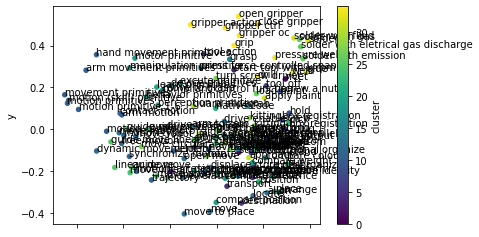

In [32]:
# Create scatter upon cluster type
ax1 = cluster.plot.scatter(x='x', y='y', c='cluster', colormap='viridis')    

for idx, row in cluster.iterrows(): 
    plt.text(row['x'], row['y'], row['primitive'])

# Try the tree approach branches
# https://scikit-learn.org/stable/auto_examples/cluster/plot_agglomerative_dendrogram.html#sphx-glr-auto-examples-cluster-plot-agglomerative-dendrogram-py

# We can apply the links directly on the figure:
#https://stackoverflow.com/questions/40871268/how-to-add-hyperlink-to-pdf-using-matplotlib


In [ ]:
byCluster = cluster.groupby('cluster')

print(len(byCluster))

for clusterNr in range(len(byCluster)):
  #print(clusterGroup)

  displayCluster = byCluster.get_group(clusterNr)

  #print(displayCluster)

  ax1 = displayCluster.plot.scatter(x='x', y='y')

  # Plot name for each datapoint
  for idx, row in displayCluster.iterrows(): 
    plt.text(row['x'], row['y'], row['primitive'])

  #plt.savefig("D:/1. Papers/4. MyPapers/6_(20210609) Skill taxonomy/skill-taxonomy-extraction/data/out/" + str(clusterNr) + ".png")
    

Here we apply agglomerative clustering from scipy following this [guide](https://scikit-learn.org/stable/auto_examples/cluster/plot_agglomerative_dendrogram.html#sphx-glr-auto-examples-cluster-plot-agglomerative-dendrogram-py)

In [47]:
import numpy as np

from matplotlib import pyplot as plt
from scipy.cluster.hierarchy import dendrogram
from scipy.cluster.hierarchy import fcluster
from sklearn.cluster import AgglomerativeClustering

dataset = sentence_embeddings


# setting distance_threshold=0 ensures we compute the full tree.
model = AgglomerativeClustering(distance_threshold=0, n_clusters=None)

model = model.fit(dataset)

print(len(dataset))


140


[32, 145, 204, 220, 91, 221, 235, 236, 167, 203, 187, 228, 271, 272, 174, 182]


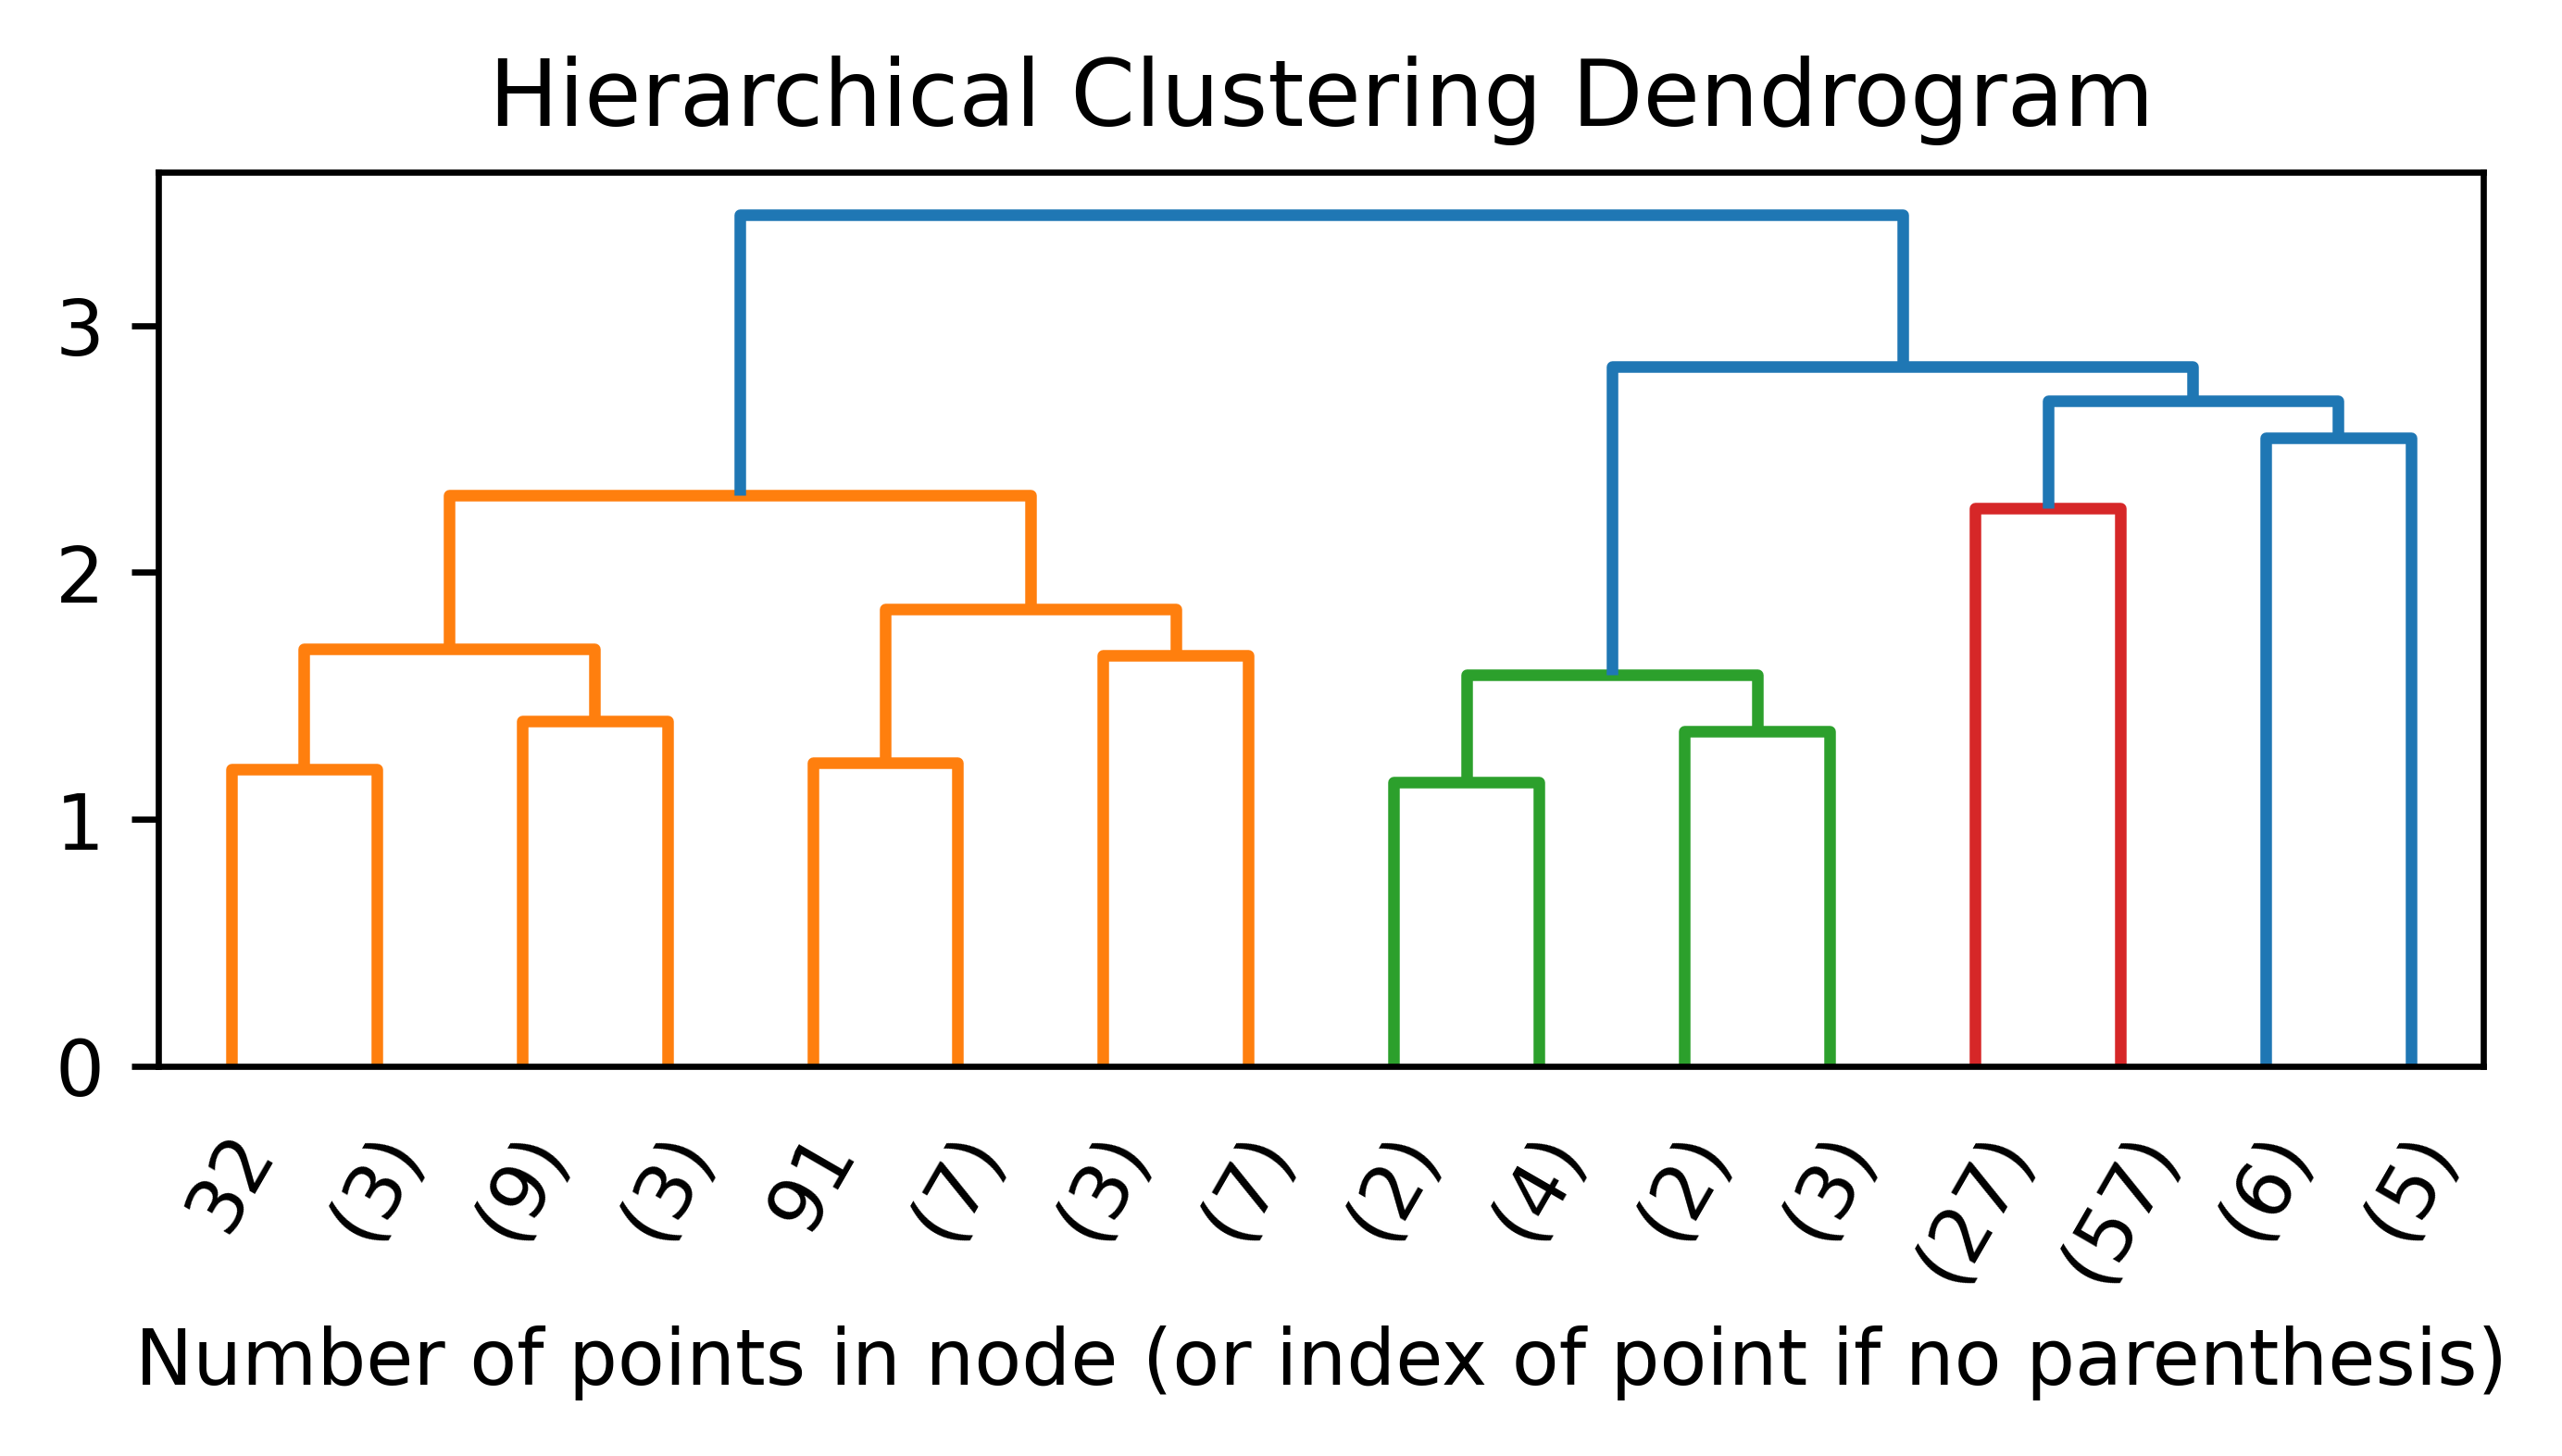

In [60]:
import numpy as np

from matplotlib import pyplot as plt
from scipy.cluster.hierarchy import dendrogram
from scipy.cluster.hierarchy import fcluster
from sklearn.cluster import AgglomerativeClustering

def plot_dendrogram(model, **kwargs):
    # Create linkage matrix and then plot the dendrogram

    # create the counts of samples under each node
    counts = np.zeros(model.children_.shape[0])
    n_samples = len(model.labels_)
    for i, merge in enumerate(model.children_):
        current_count = 0
        for child_idx in merge:
            if child_idx < n_samples:
                current_count += 1  # leaf node
            else:
                current_count += counts[child_idx - n_samples]
        counts[i] = current_count

    linkage_matrix = np.column_stack(
        [model.children_, model.distances_, counts]
    ).astype(float)

    # Plot the corresponding dendrogram
    dendo = dendrogram(linkage_matrix, **kwargs)

    return linkage_matrix, dendo

plt.figure(figsize=(3240/600, 1280/600), dpi=600)
plt.title("Hierarchical Clustering Dendrogram")
# plot the top three levels of the dendrogram

p = 3
linkageMatrix, dendoPlot = plot_dendrogram(model, truncate_mode="level", p=p, leaf_rotation=60.,leaf_font_size=10.)
plt.xlabel("Number of points in node (or index of point if no parenthesis)")
plt.savefig('D:/1. Papers/4. MyPapers/6_(20210609) Skill taxonomy/figures/denogrammClusteringRaw.png', dpi=600, bbox_inches = 'tight')
print(dendoPlot["leaves"])

label = fcluster(linkageMatrix, 16, criterion='maxclust')

print(label)

d = {'primitive': defSing, 'label':label}
#print(d)

hierarchies = pd.DataFrame(d)


Following this [guide](https://towardsdatascience.com/keyword-extraction-with-bert-724efca412ea)

In [61]:
import numpy as np

from matplotlib import pyplot as plt
from scipy.cluster.hierarchy import dendrogram
from scipy.cluster.hierarchy import fcluster
from sklearn.cluster import AgglomerativeClustering
from sklearn.feature_extraction.text import CountVectorizer
from sentence_transformers import SentenceTransformer
from sklearn.metrics.pairwise import cosine_similarity

# group by "X" column
groups = hierarchies.groupby('label')

labels = []
  
# extract keys from groups
keys = groups.groups.keys()

for i in keys:

    groups.get_group(i)

    n_gram_range = (1, 1)
    stop_words = "english"

    # Extract candidate words/phrases
    count = CountVectorizer(ngram_range=n_gram_range, stop_words = stop_words).fit(groups.get_group(i)['primitive'])
    candidates = count.get_feature_names()

    model = SentenceTransformer('msmarco-distilbert-base-tas-b')
    doc_embedding = model.encode(groups.get_group(i)['primitive'].to_list())
    candidate_embeddings = model.encode(candidates)

    top_n = 2
    distances = cosine_similarity(doc_embedding, candidate_embeddings)
    keywords = [candidates[index] for index in distances.argsort()[0][-top_n:]]
    print("GROUP: " + str(i))
    print(keywords)

    matchedKeywords = str(keywords[0] + "-" + keywords[1])
    print(matchedKeywords)

    
    labels.append(matchedKeywords)

    # put keywords on the hierechical clustering

print(labels)

GROUP: 1
['motion', 'arm']
motion-arm
GROUP: 2
['place', 'position']
place-position
GROUP: 3
['transition', 'edge']
transition-edge
GROUP: 4
['detection', 'detect']
detection-detect
GROUP: 5
['turn', 'pivot']
turn-pivot
GROUP: 6
['displace', 'retract']
displace-retract
GROUP: 7
['set', 'output']
set-output
GROUP: 8
['locate', 'action']
locate-action
GROUP: 9
['paint', 'load']
paint-load
GROUP: 10
['drive', 'motor']
drive-motor
GROUP: 11
['store', 'desorganized']
store-desorganized
GROUP: 12
['synchronize', 'synchronization']
synchronize-synchronization
GROUP: 13
['grab', 'grasp']
grab-grasp
GROUP: 14
['locate', 'place']
locate-place


In [221]:
print((labels))

['zero-arm', 'movement-motion', 'position-open', 'guard-slide', 'guide-circular', 'compare-position', 'check-input', 'flip-turn', 'grab-grasp', 'plug-insert', 'pressure-weld', 'nut-screw', 'output-unset', 'snap-press', 'paint-load', 'native-code', 'drive-enable', 'object-registration', 'parallel-sequential', 'organize-store', 'perception-manipulation', 'locate-search']


In [58]:
import numpy as np

from matplotlib import pyplot as plt
from scipy.cluster.hierarchy import dendrogram
from scipy.cluster.hierarchy import fcluster
from sklearn.cluster import AgglomerativeClustering

dataset = sentence_embeddings

# setting distance_threshold=0 ensures we compute the full tree.
model = AgglomerativeClustering(distance_threshold=0, n_clusters=None)

model = model.fit(dataset)

print(len(dataset))


temp = {dendoPlot["leaves"][ii]: labels[ii] for ii in range(len(dendoPlot["leaves"]))}

print(len(dendoPlot["leaves"]))

def llf(xx):
    #print("{} - custom label!".format(temp[xx]))
    return "{}".format(temp[xx])

plt.title("Hierarchical Clustering Dendrogram")
linkageMatrix, dendoPlot = plot_dendrogram(model, truncate_mode="lastp", p=p, leaf_label_func=llf,leaf_rotation=60.,leaf_font_size=8., show_contracted=True)
plt.xlabel("Keywords expressing each cluster")

140


IndexError: list index out of range

We now follow the guide of topic modelling, [guide](https://towardsdatascience.com/topic-modeling-with-bert-779f7db187e6)

In [351]:
import umap
umap_embeddings = umap.UMAP(n_neighbors=15, 
                            n_components=10, 
                            metric='cosine').fit_transform(sentence_embeddings)

In [352]:
import hdbscan
cluster = hdbscan.HDBSCAN(min_cluster_size=5,
                          metric='euclidean',                      
                          cluster_selection_method='eom').fit(umap_embeddings)

7


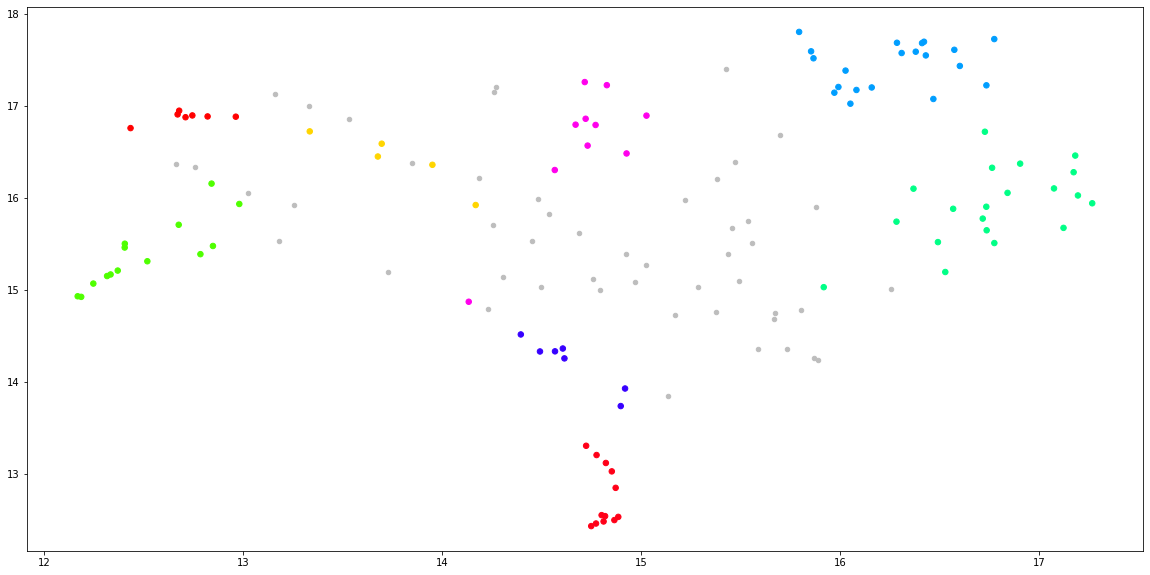

In [353]:
import matplotlib.pyplot as plt

# Prepare data
umap_data = umap.UMAP(n_neighbors=15, n_components=2, min_dist=0.0, metric='cosine').fit_transform(sentence_embeddings)
result = pd.DataFrame(umap_data, columns=['x', 'y'])
result['labels'] = cluster.labels_

#print(result)

# Visualize clusters
fig, ax = plt.subplots(figsize=(20, 10))
outliers = result.loc[result.labels == -1, :]
clustered = result.loc[result.labels != -1, :]
print(max(result.labels))
plt.scatter(outliers.x, outliers.y, color='#BDBDBD', s=20)
plt.scatter(clustered.x, clustered.y, c=clustered.labels, s=30, cmap='hsv_r')
#plt.colorbar()

In [361]:
d = {'primitive':defSing, 'cluster':result['labels'], 'x': result['x'], 'y': result['y']}

clusterDF = pd.DataFrame(d)
clusterDF['Doc_ID'] = range(len(clusterDF))

primitivesPerTopic = clusterDF.groupby(['cluster'], as_index = False).agg({'primitive': ' '.join})

print(primitivesPerTopic.primitive.values)

print(clusterDF)

['store fractrional organize sync convery destination drive put arrange retreat excute move to grasp insert displace place bond release plug sequential or parallel orient search transport drive pose learn reach set output before drive enable store desorganized after manipulation arm to zero locate action align start tool with x rpm screw carry approach press force-controlled snap tool action push guard approach service fee guard slide position pick synchronization point capture point cloud turn screw driver home store organize'
 'compare presence compare orientation compare form detect distance perception detect compare identity color base detection compare weight compare collour compare position check input'
 'spin back unset output flip rotate retract spin turn pivot slide ff planer'
 'kitting box registration code object train object registration native code approach boxbottom kittingbox registration'
 'motor arm motion synchronize motion contact motion movement s velocity motion ty

As suggested by this [guide](https://towardsdatascience.com/keyword-extraction-with-bert-724efca412ea)

In [365]:
from sklearn.feature_extraction.text import CountVectorizer
from sentence_transformers import SentenceTransformer
from sklearn.metrics.pairwise import cosine_similarity
# group by "X" column
groups = primitivesPerTopic.groupby('cluster')
  
# extract keys from groups
keys = groups.groups.keys()

for i in keys:

    groups.get_group(i)

    n_gram_range = (1, 1)
    stop_words = "english"

    # Extract candidate words/phrases
    count = CountVectorizer(ngram_range=n_gram_range, stop_words=stop_words).fit(groups.get_group(i)['primitive'])
    candidates = count.get_feature_names()

    model = SentenceTransformer('msmarco-distilbert-base-tas-b')
    doc_embedding = model.encode(groups.get_group(i)['primitive'].to_list())
    candidate_embeddings = model.encode(candidates)

    top_n = 2
    distances = cosine_similarity(doc_embedding, candidate_embeddings)
    keywords = [candidates[index] for index in distances.argsort()[0][-top_n:]]
    print("GROUP: " + str(i))
    print(keywords)

    # need to add names to each of the group for visualization

Downloading: 100%|██████████| 690/690 [00:00<00:00, 346kB/s]
Downloading: 100%|██████████| 3.95k/3.95k [00:00<00:00, 3.95MB/s]
Downloading: 100%|██████████| 229/229 [00:00<00:00, 115kB/s]
Downloading: 100%|██████████| 265M/265M [00:28<00:00, 9.16MB/s] 
Downloading: 100%|██████████| 53.0/53.0 [00:00<00:00, 17.7kB/s]
Downloading: 100%|██████████| 112/112 [00:00<00:00, 111kB/s]
Downloading: 100%|██████████| 466k/466k [00:00<00:00, 649kB/s] 
Downloading: 100%|██████████| 547/547 [00:00<00:00, 554kB/s]
Downloading: 100%|██████████| 232k/232k [00:00<00:00, 561kB/s] 
Downloading: 100%|██████████| 190/190 [00:00<00:00, 193kB/s]


GROUP: -1
['grasp', 'drive']
GROUP: 0
['detect', 'detection']
GROUP: 1
['spin', 'flip']
GROUP: 2
['boxbottom', 'kittingbox']
GROUP: 3
['arm', 'motion']
GROUP: 4
['cartesian', 'circular']
GROUP: 5
['weld', 'solder']
GROUP: 6
['grab', 'grasp']
GROUP: 7
['opengripper', 'gripper']


KeyError: 'recurringWord'

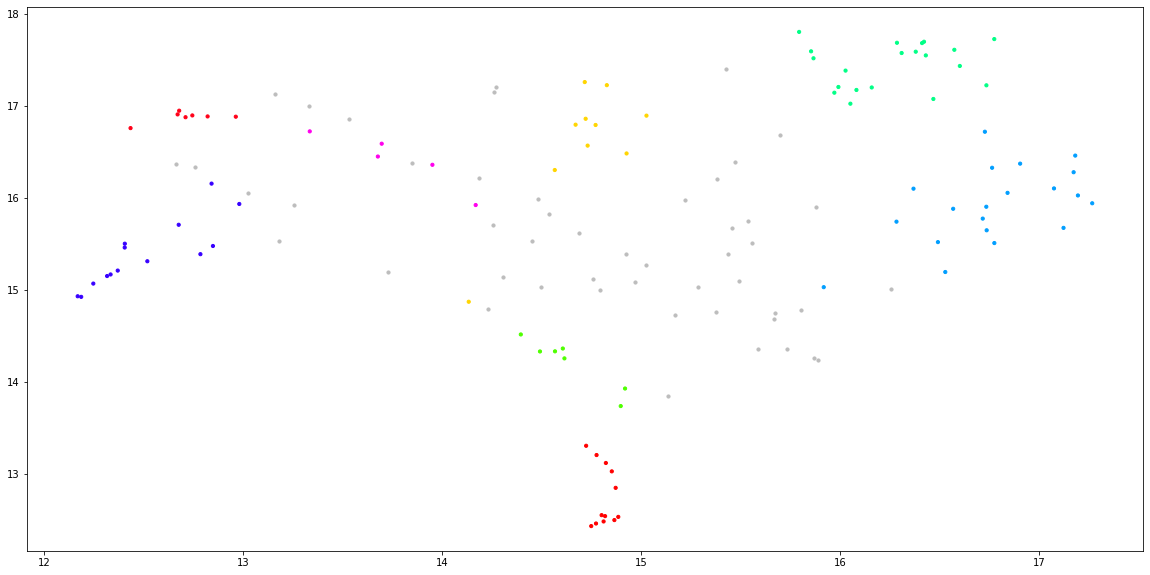

In [364]:



# Visualize clusters
fig, ax = plt.subplots(figsize=(20, 10))
outliers = clusterDF.loc[clusterDF.cluster == -1, :]
clustered = clusterDF.loc[clusterDF.cluster != -1, :]
#print(clustered.keys())
plt.scatter(outliers.x, outliers.y, color='#BDBDBD', s=10)
plt.scatter(clustered.x, clustered.y, c=clustered.cluster, s=10, cmap='hsv')
#plt.colorbar()

#loop through labels and plot each cluster

# group by "X" column
groups = clustered.groupby('cluster')
  
# extract keys from groups
keys = groups.groups.keys()

for i in keys:

    x = groups.get_group(i)['x'].mean()
    y = groups.get_group(i)['y'].mean()
    
    plt.annotate(groups.get_group(i).iloc[0]["recurringWord"], xy = (x,y))
